### Gaussian Process Modeling for Chronovirus cases
this is based on code adapted from https://peterroelants.github.io/posts/gaussian-process-tutorial/

The following is a simple use of Gaussian Process models to understand the trends in the chronovirus data.  It is not a very detained attempt to do regression or prediction, but it does illustrate how one can build a model and draw possible future paths from the data. 

In [1]:
#!pip install --upgrade google-cloud-bigquery[pandas]
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import scipy
import matplotlib
import numpy as np

#### Pull the data from Google Cloud
The Covid-19 data is in the Goole cloud uploaded from the New York times.  To run this you must have a google cloud account which is free for simple first-time use.    

We will run google's bigquery to extract the data and we will run it through a client in the notebook here.
To run this you must have a google cloud account which is free for simple first-time use.   

You will need to add the json package containing you service account key to your environment variables and described here.  Finally install the local libraries with this command on your machine.

pip install --upgrade google-cloud-bigquery[pandas]

Next load the bigquery library and create the client.

In [2]:
%load_ext google.cloud.bigquery

In [3]:
from google.cloud import bigquery
client = bigquery.Client()
import pandas  as pd

we will first demonstrate the bigquerry by running a simple querry to get the dates, number of cases and deaths for Washington State.

In [4]:
%%bigquery
SELECT
    date AS date, confirmed_cases AS cases, deaths as deaths
FROM `bigquery-public-data.covid19_nyt.us_states`
WHERE
    state_name="Washington"
LIMIT 10

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,1,0
4,2020-01-25,1,0
5,2020-01-26,1,0
6,2020-01-27,1,0
7,2020-01-28,1,0
8,2020-01-29,1,0
9,2020-01-30,1,0


Becuase we would like to capture the full output as a pandas dataframe we will run the query with the client.

In [5]:
q ="""
SELECT
    date AS date, confirmed_cases AS cases, deaths as deaths
FROM `bigquery-public-data.covid19_nyt.us_states`
WHERE
    state_name="Washington"
"""

In [6]:
dflist = client.query(q).to_dataframe() 

In [7]:
dflist

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,1,0
4,2020-01-25,1,0
...,...,...,...
158,2020-06-27,33031,1311
159,2020-06-28,33341,1311
160,2020-06-29,34036,1321
161,2020-06-30,34541,1333


The following function allows us to extract the list of confirmed cases as an numpy array

In [38]:
def make_data(dflist):
    a = dflist
    groups = a.groupby(['date', 'cases', 'deaths']).groups
    myalist = []
    for date, cases, deaths  in groups:
        myalist.append((date, cases, deaths))
    lastc = 0
    lastd = 0
    newlist = []
    for rec in myalist:
        newlist.append((rec[1]-lastc, rec[2]-lastd))
        lastc = rec[1]
        lastd = rec[2]
    ar = np.array(newlist)
    return ar[:,0]


In [39]:
ar_wash = make_data(dflist)

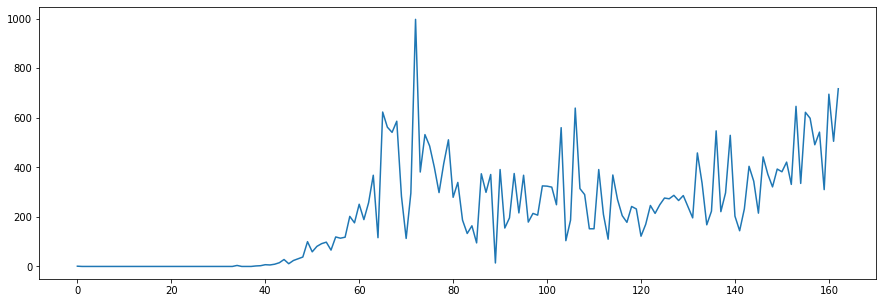

In [40]:
plt.figure( figsize=(15,5))
plt.plot(ar_wash)

The following code is from Peter Roelandt's blog cited above.   

In [11]:
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

In [12]:
def GP_noise(X1, y1, X2, kernel_func, σ_noise, n1):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the noisy observations 
    (y1, X1), and the prior kernel function.
    """
    # Kernel of the noisy observations
    Σ11 = kernel_func(X1, X1) + σ_noise * np.eye(n1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [44]:
# The function that we will use to create and plot the shape of the Gaussian process and draw three sample function.
# data is the full data set we have access to
# scale is a way to scale the data down to a level where Gaussian process function works. it requres experiments to
#    get a good scale factor.   
#n1 is the numbere of sample from the data we will use.
#days is the interval between samples.
#k is σ_noise parameter used by the GP_noise algorithm.  
def make_gaussian( data, scale = 0.001, n1=240, days=15, k=0.1):
    ny = 3
    n2 = len(data)
    y = data[0:n2]*scale
    # the prior time interval is one year (365 days) normalized by 0.01.
    # In case we have less that one years data we stretch it out by sampling n2 days uniformly
    X2 = np.linspace(0, 3.65, n2).reshape(-1,1)
    i1 = [i*days for i in range(int(n1/days))]
    short =  len(i1)
    X1 = np.zeros(short)
    y_samp = np.zeros(short)
    #X1 and y_samp are the points we will use for the sample.
    for i in range(short):
        #print(i)
        X1[i]= X2[i1[i]]
        y_samp[i] = y[i1[i]]
    #y_samp[i] = y[0]
    X1 = X1.reshape(short,1)
    y_samp = y_samp.reshape(short,1)
    # Compute posterior mean and covariance
    μ2, Σ2 = GP_noise(X1, y_samp, X2, exponentiated_quadratic, k, short)
    # Compute the standard deviation at the test points to be plotted
    σ2 = np.sqrt(np.diag(Σ2)).reshape(-1,1)
    # Draw ny samples of the posterior
    y2 = np.random.multivariate_normal(mean=μ2.reshape(n2), cov=Σ2, size=ny)
    
    fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,  figsize=(10,10))
    # Plot the distribution of the function (mean, covariance)
    ax1.plot(X2, y, 'b--', label='$raw data$')
    ax1.plot(X2, y2.T, '-')

    xx = X1
    yy = y_samp
    ax1.scatter(xx,yy, s=30, color='red')

    u = μ2-2*σ2
    v = μ2+2*σ2
    u = u.reshape(n2)
    v = v.reshape(n2)
    ax1.fill_between(X2.flat, u,v, color='red', 
                     alpha=0.15, label='$2\sigma_{2|1}$')
    ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
    #ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
    #ax1.set_xlabel('$x$', fontsize=13)
    #ax1.set_ylabel('$y$', fontsize=13)
    print("confirmed cases from %s to %s"%(dflist['date'][0], dflist['date'][dflist.last_valid_index()]))
    #print(s)
    ax1.set_title("Distribution of posterior and prior data")
    ax1.legend()
    # Plot some samples from this function
    ax2.plot(X2, y2.T, '-')
    ax2.set_xlabel('$x$', fontsize=13)
    ax2.set_ylabel('$y$', fontsize=13)
    ax2.set_title('3 different function realizations from posterior')
    #ax1.axis([domain[0], domain[1], -3, 3])
    #ax2.set_xlim([-6, 6])
    plt.tight_layout()
    plt.show()

    err = 0.0
    errsq  = 0.0
    cnt = 0
    badday  =0.0
    u = scale*μ2.reshape(n2)
    for i in range(n2):
        err += np.abs(data[i]-u[i])
        errsq += np.abs(data[i]-u[i])*np.abs(data[i]-u[i])
        if (data[i]-u[i]) > 10 or (data[i]-u[i]) < -10:
            #print (realdata[i]-actual_predictions[i])
            badday += np.abs(data[i]-u[i])
            cnt +=1
    print("l1 error=", err/(n2))
    err = np.sqrt(errsq)/(n2)
    print("l2 error=", err)
    #print('days over 10 points wrong =', cnt)
    #if cnt > 0:
    #    print("average bad day = ", badday/cnt)    
    return μ2

We compute the gp for the washington state data.   we have stipulated that we will sample the data up to 10 days befor the end of the known confirmed cases and we sample every 9 days up to the point.  

As can be seen the gaussian process mean (read line) and the 2sigma band misses most of the data, but the trend is clear.

confirmed cases from 2020-01-21 to 2020-07-01


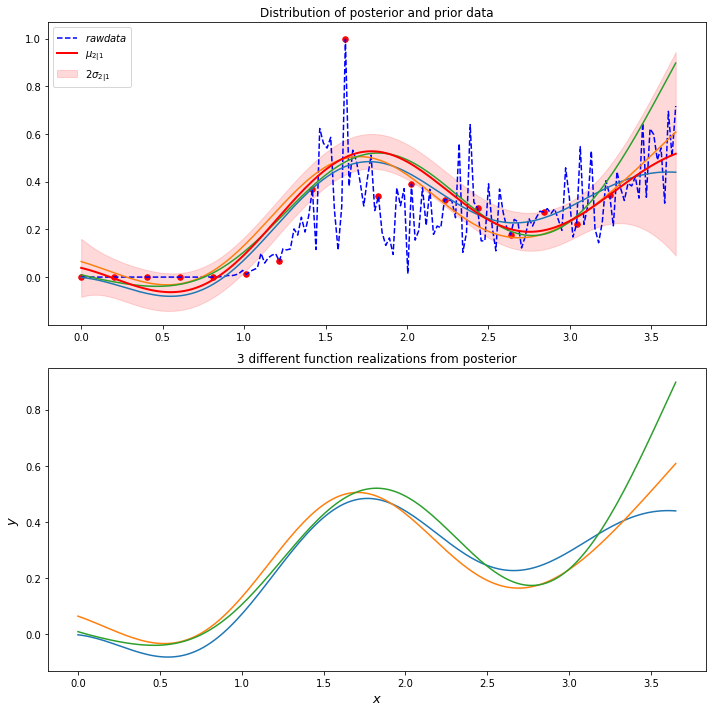

l1 error= 216.30650119376406
l2 error= 22.99827840408925


In [45]:
u2 = make_gaussian(ar_wash, scale=0.001, n1=len(ar_wash)-10, days=9, k=0.005) 

To show the sensitivity to the different parameters, let us sample more often. as shwon below, sampling more often actuall gives a result that is not very good for the last 10 days.  (however one of the samples drawn is good.)

confirmed cases from 2020-01-21 to 2020-07-01


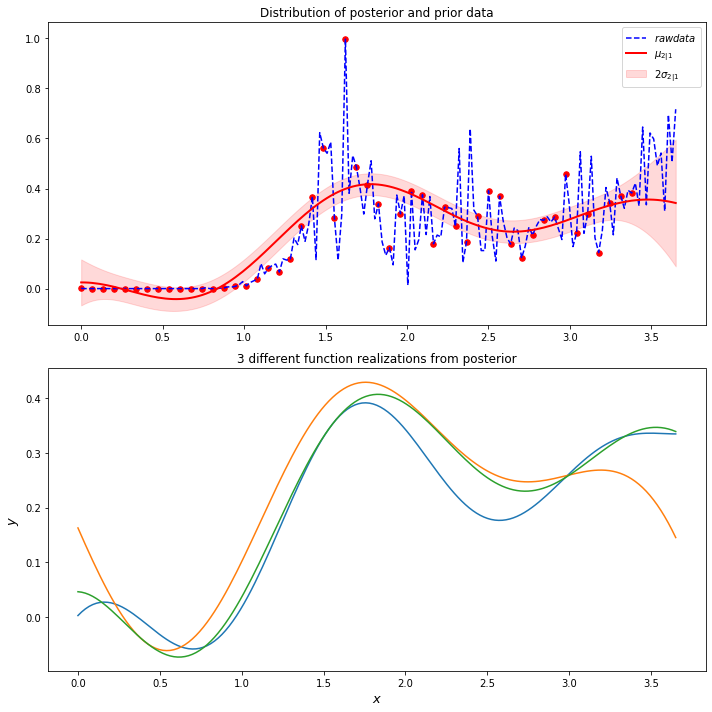

l1 error= 216.3065328632494
l2 error= 22.998281755551957


In [15]:
u2 = make_gaussian(ar_wash, n1=len(ar_wash)-10, days=3, k=0.005) 

taking the samples up to 4 days prior to the end and sampling ever 5 days gives a good match. 

confirmed cases from 2020-01-21 to 2020-07-01


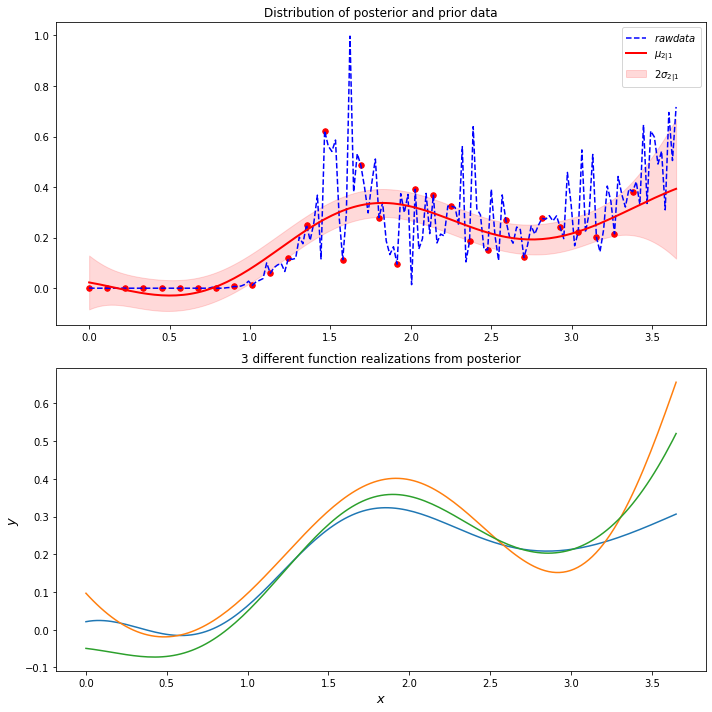

l1 error= 216.3065622042163
l2 error= 22.998284251478932


In [16]:
u2 = make_gaussian(ar_wash, n1=len(ar_wash)-4, days=5, k=0.005) 

We can take a look at the data for several other states.

In [17]:
q ="""
SELECT
    date AS date, confirmed_cases AS cases, deaths as deaths
FROM `bigquery-public-data.covid19_nyt.us_states`
WHERE
    state_name="Georgia"
"""

In [18]:
dflist_georgia = client.query(q).to_dataframe() 


confirmed cases from 2020-01-21 to 2020-07-01


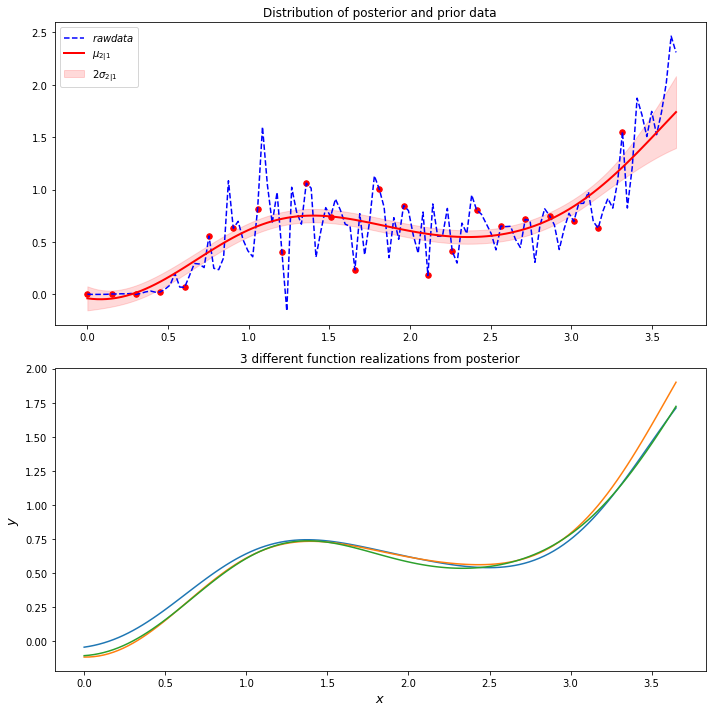

l1 error= 654.9583901562472
l2 error= 74.22715951608053


In [21]:
ar_georgia = make_data(dflist_georgia)
u2 = make_gaussian(ar_georgia, scale=0.001, n1=len(ar_georgia)-5, days=5, k=0.005) 

In [22]:
q ="""
SELECT
    date AS date, confirmed_cases AS cases, deaths as deaths
FROM `bigquery-public-data.covid19_nyt.us_states`
WHERE
    state_name="Florida"
"""
dflist_florida = client.query(q).to_dataframe() 

In [23]:
ar_florida = make_data(dflist_florida)

confirmed cases from 2020-01-21 to 2020-07-01


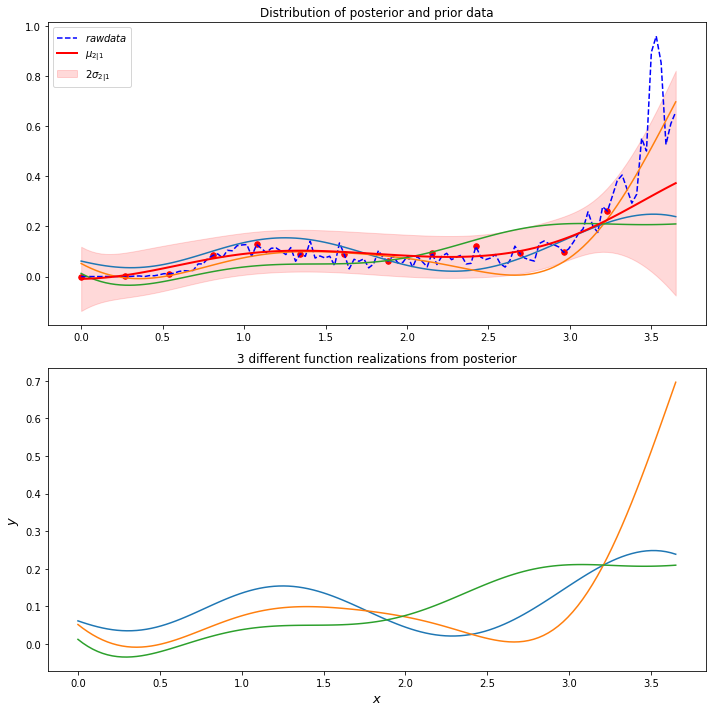

l1 error= 1292.5934850137041
l2 error= 195.45020902145143


In [65]:
u2 = make_gaussian(ar_florida, scale=0.0001, n1=len(ar_florida)-5, days=9, k=0.005) 

In [27]:
q ="""
SELECT
    date AS date, confirmed_cases AS cases, deaths as deaths
FROM `bigquery-public-data.covid19_nyt.us_states`
WHERE
    state_name="California"
"""
dflist_california = client.query(q).to_dataframe()
ar_california = make_data(dflist_california)

confirmed cases from 2020-01-21 to 2020-07-01


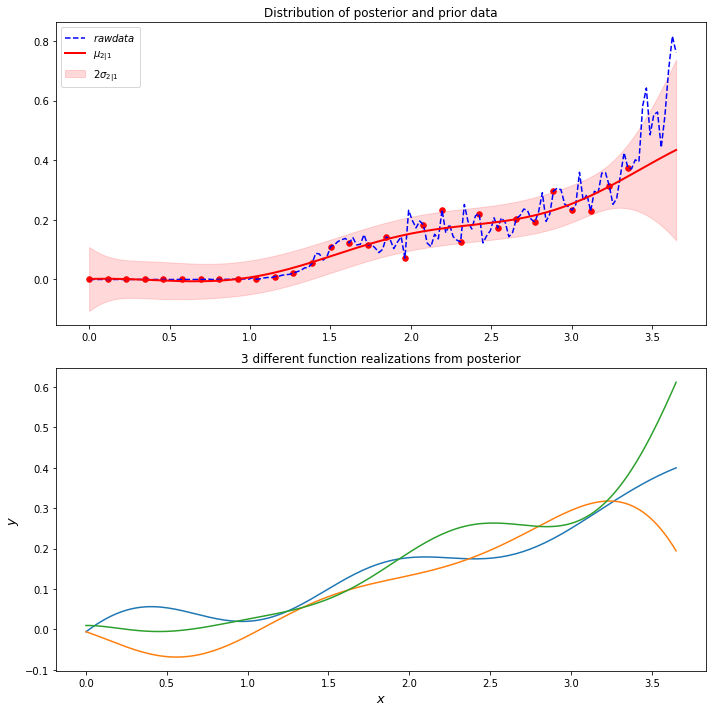

l1 error= 1507.949671997961
l2 error= 177.95688019373125


In [28]:
u2 = make_gaussian(ar_california, scale=0.0001, n1=len(ar_california)-5, days=5, k=0.005) 

In [29]:
q ="""
SELECT
    date AS date, confirmed_cases AS cases, deaths as deaths
FROM `bigquery-public-data.covid19_nyt.us_states`
WHERE
    state_name="New York"
"""
dflist_nyc = client.query(q).to_dataframe()
ar_nyc = make_data(dflist_nyc)

confirmed cases from 2020-01-21 to 2020-07-01


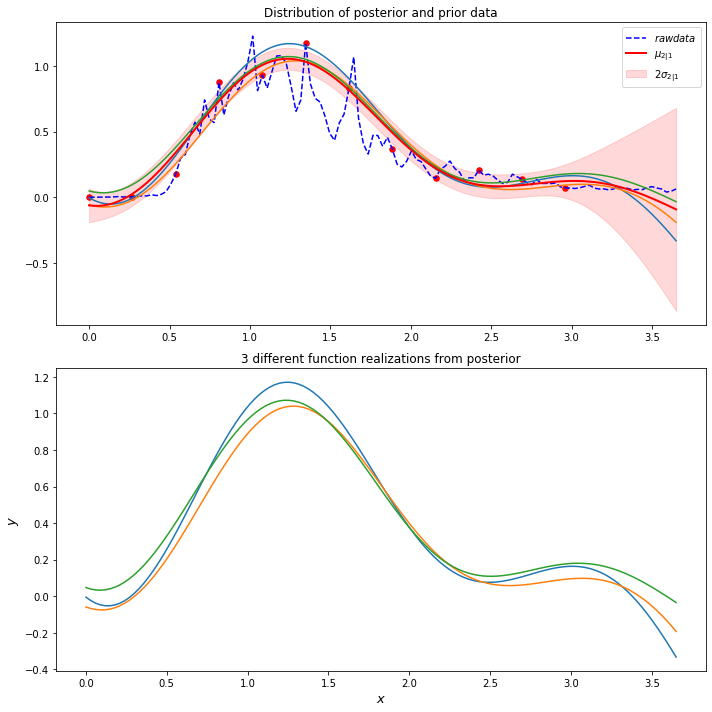

l1 error= 3242.032483649976
l2 error= 418.2862775942513


In [62]:
u2 = make_gaussian(ar_nyc, scale=0.0001, n1=len(ar_nyc)-10, days=9, k=0.005) 

In [31]:
q ="""
SELECT
    date AS date, confirmed_cases AS cases, deaths as deaths
FROM `bigquery-public-data.covid19_nyt.us_states`
WHERE
    state_name="Texas"
"""
dflist_texas = client.query(q).to_dataframe()
ar_texas = make_data(dflist_texas)

confirmed cases from 2020-01-21 to 2020-07-01


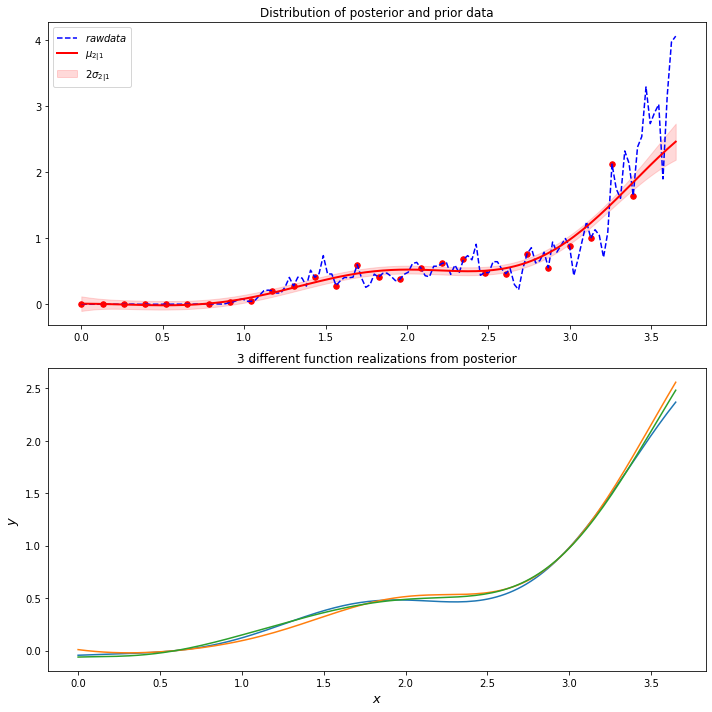

l1 error= 1239.9004255579857
l2 error= 171.62629540682735


In [33]:
u2 = make_gaussian(ar_texas, scale=0.0005, n1=len(ar_texas)-5, days=5, k=0.005) 

In [34]:
dflist_texas

,date,cases,deaths
0,2020-02-12,1,0
1,2020-02-13,2,0
2,2020-02-14,2,0
3,2020-02-15,2,0
4,2020-02-16,2,0
...,...,...,...
136,2020-06-27,148639,2398
137,2020-06-28,152437,2407
138,2020-06-29,158756,2430
139,2020-06-30,166703,2482
